In [53]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Acceptance Criteria

## Load the MNIST dataset.

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True,)
print(X.shape, y.shape)

(70000, 784) (70000,)


## Sanity Checks & Dtypes

In [8]:
print("X dtype before:", X.dtypes)
print("y dtype before:", y.dtypes) 

X dtype before: pixel1      float64
pixel2      float64
pixel3      float64
pixel4      float64
pixel5      float64
             ...   
pixel780    float64
pixel781    float64
pixel782    float64
pixel783    float64
pixel784    float64
Length: 784, dtype: object
y dtype before: category


## Normalize Pixels to [0, 1] + Clean Labels

In [3]:
X = X/255

In [4]:
X.values[0].shape

(784,)

In [9]:
# Normalize features and clean labels
X = X.astype("float32") / 255.0   # float32 is efficient
y = y.astype("int64")             # ensure labels are integers

print(X.shape, y.shape)
print("X range:", X.min(), "→", X.max())
print("y classes:", np.unique(y))


(70000, 784) (70000,)
X range: pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Length: 784, dtype: float64 → pixel1      0.000000
pixel2      0.000000
pixel3      0.000000
pixel4      0.000000
pixel5      0.000000
              ...   
pixel780    0.000953
pixel781    0.000000
pixel782    0.000000
pixel783    0.000000
pixel784    0.000000
Length: 784, dtype: float64
y classes: [0 1 2 3 4 5 6 7 8 9]


## Train/Test Split (Stratified)

In [10]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,           # 80/20 split
    stratify=y,               # preserve class balance
    random_state=RANDOM_STATE # reproducibility
)

X_train.shape, X_test.shape

((56000, 784), (14000, 784))

## Image Views for Plotting

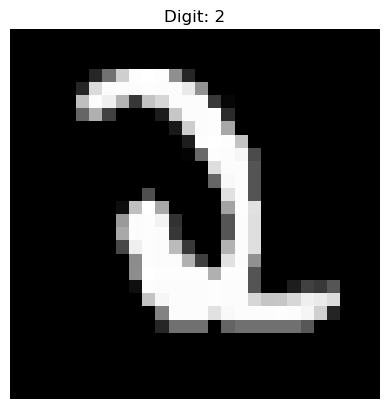

In [11]:
image_index = 400
image_data = X.values[image_index].reshape(28, 28)

# Display the image
plt.imshow(image_data, cmap='gray') # 'gray_r' for reversed grayscale (black digits on white background)
plt.title(f"Digit: {y[image_index]}") # Display the corresponding digit label
plt.axis('off') # Turn off axis labels for a cleaner image display
plt.show()

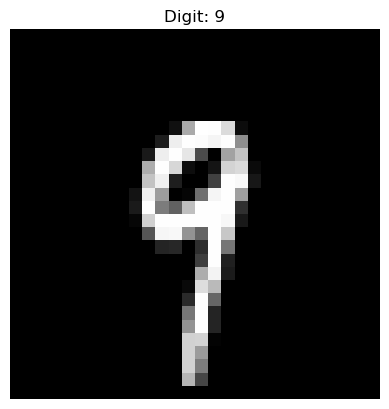

In [12]:
image_index = 600
image_data = X.values[image_index].reshape(28, 28)

# Display the image
plt.imshow(image_data, cmap='gray') # 'gray_r' for reversed grayscale (black digits on white background)
plt.title(f"Digit: {y[image_index]}") # Display the corresponding digit label
plt.axis('off') # Turn off axis labels for a cleaner image display
plt.show()

## Model Training

In [13]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,           # 80/20 split
    stratify=y,               # preserve class balance
    random_state=RANDOM_STATE # reproducibility
)

X_train.shape, X_test.shape

((56000, 784), (14000, 784))

## Logistic Regression

### Scaling helps linear models converge.
### with_mean=False avoids subtracting means on high-dimensional flat features (treat as sparse-like).
### multi_class="multinomial" uses the proper softmax formulation.

In [16]:
RANDOM_STATE = 42

# Multinomial Logistic Regression generally works best for MNIST
logreg = make_pipeline(
    StandardScaler(with_mean=False),                      # scale features (no centering for sparse-like data)
    LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=RANDOM_STATE)
)

t0 = time.perf_counter()
logreg.fit(X_train, y_train)
logreg_train_time = time.perf_counter() - t0
print(f"Training time (LogReg): {logreg_train_time:.2f}s")

C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training time (LogReg): 37.22s


## Evaluate Logistic Regression (Report & Accuracy)

In [17]:
t1 = time.perf_counter()
y_pred_logreg = logreg.predict(X_test)
logreg_infer_time = time.perf_counter() - t1

logreg_acc = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy (LogReg): {logreg_acc:.4f}  |  Inference time: {logreg_infer_time:.2f}s\n")

print("Classification Report — Logistic Regression")
print(classification_report(y_test, y_pred_logreg, digits=4))

Accuracy (LogReg): 0.9161  |  Inference time: 0.19s

Classification Report — Logistic Regression
              precision    recall  f1-score   support

           0     0.9481    0.9652    0.9566      1381
           1     0.9494    0.9651    0.9572      1575
           2     0.9147    0.8898    0.9021      1398
           3     0.8932    0.8901    0.8916      1428
           4     0.9253    0.9077    0.9164      1365
           5     0.8749    0.8694    0.8721      1263
           6     0.9350    0.9527    0.9438      1375
           7     0.9226    0.9390    0.9307      1459
           8     0.8914    0.8784    0.8849      1365
           9     0.8968    0.8929    0.8948      1391

    accuracy                         0.9161     14000
   macro avg     0.9151    0.9150    0.9150     14000
weighted avg     0.9159    0.9161    0.9160     14000



### classification_report shows precision/recall/F1 per digit and macro/weighted averages.

## Confusion Matrix (Logistic Regression)

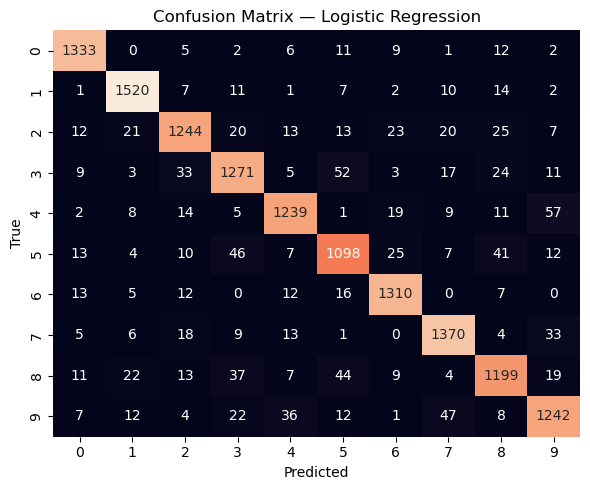

In [18]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg, labels=list(range(10)))

plt.figure(figsize=(6,5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cbar=False,
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()

## Misclassified Samples (Logistic Regression)

In [20]:
def show_misclassified(X_test, y_true, y_pred, n=9, img_size=(28, 28), title="Misclassified — Logistic Regression"):
    # --- Convert any pandas objects to NumPy arrays to avoid .iloc/.loc pitfalls ---
    X = X_test.to_numpy() if hasattr(X_test, "to_numpy") else np.asarray(X_test)
    yt = y_true.to_numpy() if hasattr(y_true, "to_numpy") else np.asarray(y_true)
    yp = y_pred.to_numpy() if hasattr(y_pred, "to_numpy") else np.asarray(y_pred)

    # --- Basic checks ---
    assert X.ndim == 2, f"Expected X to be 2D (N, 784). Got {X.shape}"
    assert len(yt) == len(yp) == len(X), "X, y_true, y_pred must have the same length"

    # --- Find misclassifications ---
    wrong_idx = np.where(yt != yp)[0]
    if wrong_idx.size == 0:
        print("No misclassified samples to display.")
        return

    n = int(min(n, wrong_idx.size))
    sel = np.random.choice(wrong_idx, size=n, replace=False)

    # --- Plot grid ---
    h, w = img_size
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.atleast_2d(axes).reshape(rows, cols)

    for i, idx in enumerate(sel):
        r, c = divmod(i, cols)
        axes[r, c].imshow(X[idx].reshape(h, w), cmap="gray")
        axes[r, c].axis("off")
        axes[r, c].set_title(f"True: {yt[idx]}  Pred: {yp[idx]}")

    # Hide any unused axes
    for j in range(i + 1, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

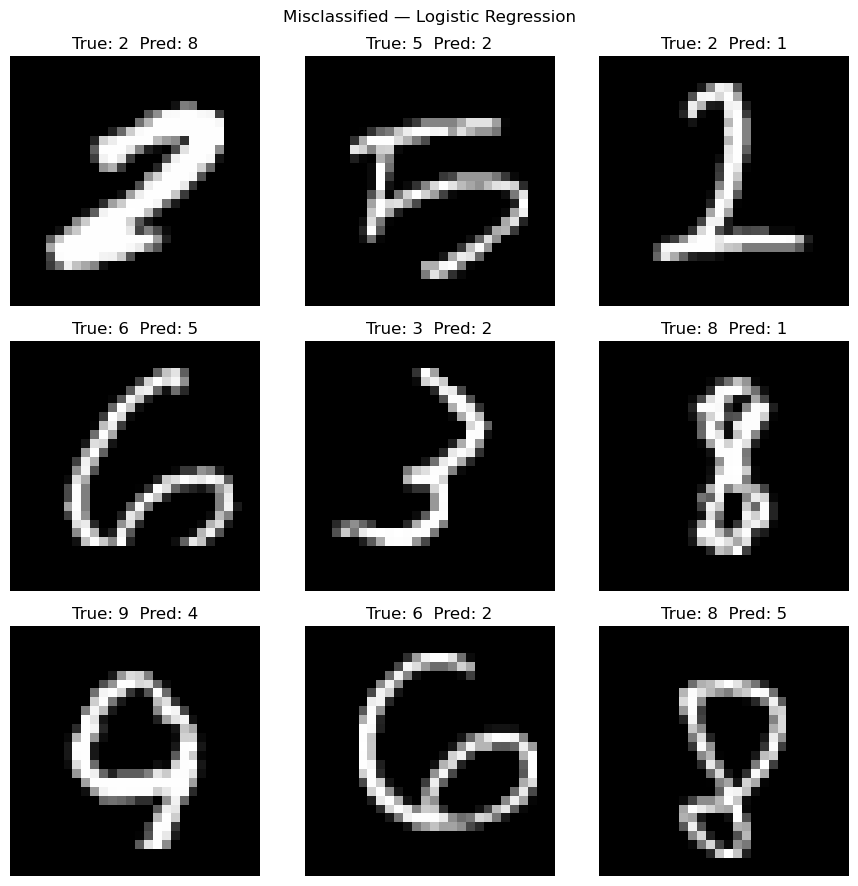

In [21]:
show_misclassified(X_test, y_test, y_pred_logreg, n=9, img_size=(28, 28), title="Misclassified — Logistic Regression")


> Seeing real failures helps you understand why the model struggles (light strokes, odd angles, ambiguous shapes).

## Support Vector Machine (SVM)

### Define & Train Linear SVM (fast baseline)

In [24]:
RANDOM_STATE = 42

lin_svm = make_pipeline(
    StandardScaler(with_mean=False),     # scale features (no centering for sparse-like data)
    LinearSVC(random_state=RANDOM_STATE, max_iter=5000)  # max_iter↑ to ensure convergence
)

t0 = time.perf_counter()
lin_svm.fit(X_train, y_train)
linsvm_train_time = time.perf_counter() - t0
print(f"Training time (Linear SVM): {linsvm_train_time:.2f}s")

Training time (Linear SVM): 3032.51s


## Evaluate Linear SVM (report + accuracy)

In [25]:
t1 = time.perf_counter()
y_pred_linsvm = lin_svm.predict(X_test)
linsvm_infer_time = time.perf_counter() - t1

linsvm_acc = accuracy_score(y_test, y_pred_linsvm)
print(f"Accuracy (Linear SVM): {linsvm_acc:.4f} | Inference time: {linsvm_infer_time:.2f}s\n")

print("Classification Report — Linear SVM")
print(classification_report(y_test, y_pred_linsvm, digits=4))

Accuracy (Linear SVM): 0.9120 | Inference time: 0.12s

Classification Report — Linear SVM
              precision    recall  f1-score   support

           0     0.9422    0.9804    0.9610      1381
           1     0.9483    0.9663    0.9572      1575
           2     0.9104    0.8863    0.8982      1398
           3     0.8895    0.8852    0.8873      1428
           4     0.9206    0.9179    0.9193      1365
           5     0.8645    0.8591    0.8618      1263
           6     0.9347    0.9578    0.9461      1375
           7     0.9211    0.9356    0.9283      1459
           8     0.8874    0.8484    0.8674      1365
           9     0.8878    0.8706    0.8791      1391

    accuracy                         0.9120     14000
   macro avg     0.9107    0.9108    0.9106     14000
weighted avg     0.9115    0.9120    0.9116     14000



## Confusion Matrix (Linear SVM)

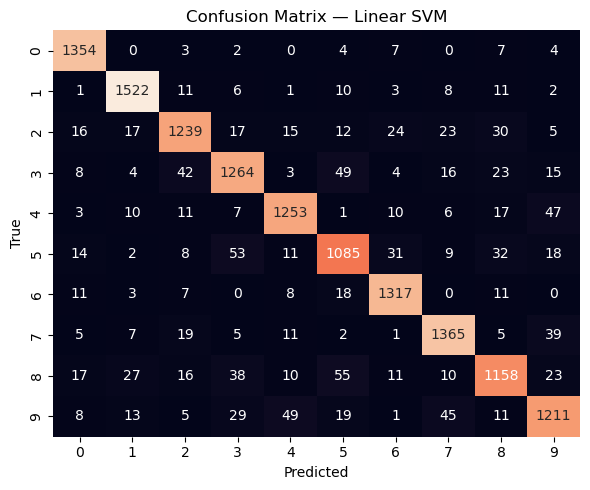

In [26]:
cm_linsvm = confusion_matrix(y_test, y_pred_linsvm, labels=list(range(10)))
plt.figure(figsize=(6,5))
sns.heatmap(cm_linsvm, annot=True, fmt="d", cbar=False,
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Linear SVM")
plt.tight_layout()
plt.show()

## Misclassified Samples (Linear SVM)

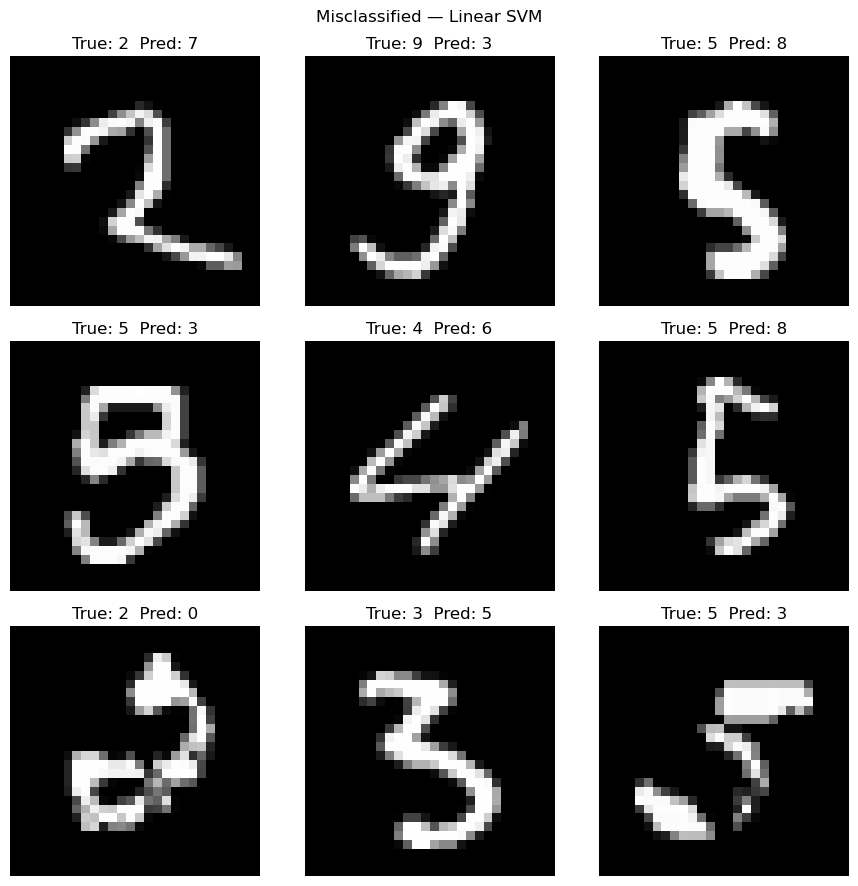

In [27]:
show_misclassified(X_test, y_test, y_pred_linsvm, n=9, img_size=(28, 28),
                   title="Misclassified — Linear SVM")


## RBF SVM — better accuracy, slower

Training time (RBF SVM on 12000 samples): 21.37s
Accuracy (RBF SVM): 0.9475 | Inference time: 49.52s

Classification Report — RBF SVM
              precision    recall  f1-score   support

           0     0.9673    0.9848    0.9760      1381
           1     0.9692    0.9803    0.9747      1575
           2     0.8789    0.9557    0.9157      1398
           3     0.9472    0.9293    0.9381      1428
           4     0.9648    0.9436    0.9541      1365
           5     0.9553    0.9311    0.9431      1263
           6     0.9574    0.9644    0.9609      1375
           7     0.9402    0.9369    0.9386      1459
           8     0.9552    0.9223    0.9385      1365
           9     0.9447    0.9216    0.9330      1391

    accuracy                         0.9475     14000
   macro avg     0.9480    0.9470    0.9473     14000
weighted avg     0.9481    0.9475    0.9475     14000



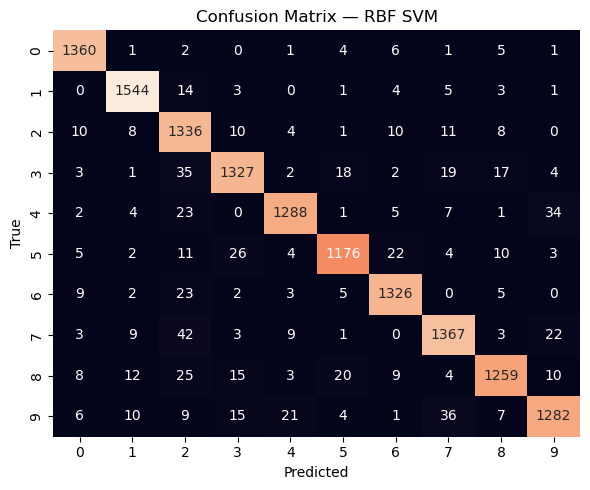

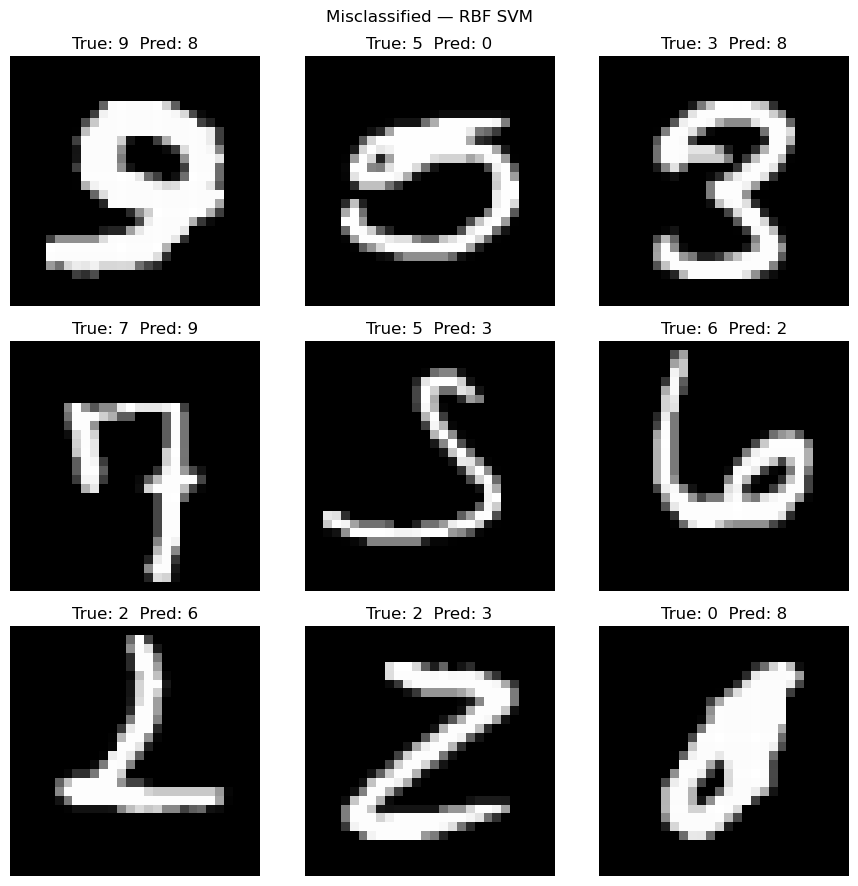

In [28]:
# Use a subset to keep runtime reasonable (adjust as you like)
SUBSET = 12000  # try 12k; raise to 20k+ if you have time/RAM

from sklearn.model_selection import train_test_split
X_tr_sub, _, y_tr_sub, _ = train_test_split(
    X_train, y_train, train_size=SUBSET, stratify=y_train, random_state=RANDOM_STATE
)

rbf_svm = make_pipeline(
    StandardScaler(with_mean=False),
    SVC(kernel='rbf', gamma='scale', C=2.0, random_state=RANDOM_STATE)
)

t0 = time.perf_counter()
rbf_svm.fit(X_tr_sub, y_tr_sub)
rbf_train_time = time.perf_counter() - t0
print(f"Training time (RBF SVM on {SUBSET} samples): {rbf_train_time:.2f}s")

t1 = time.perf_counter()
y_pred_rbf = rbf_svm.predict(X_test)
rbf_infer_time = time.perf_counter() - t1

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rbf_acc = accuracy_score(y_test, y_pred_rbf)
print(f"Accuracy (RBF SVM): {rbf_acc:.4f} | Inference time: {rbf_infer_time:.2f}s\n")
print("Classification Report — RBF SVM")
print(classification_report(y_test, y_pred_rbf, digits=4))

cm_rbf = confusion_matrix(y_test, y_pred_rbf, labels=list(range(10)))
plt.figure(figsize=(6,5))
sns.heatmap(cm_rbf, annot=True, fmt="d", cbar=False,
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — RBF SVM")
plt.tight_layout()
plt.show()

show_misclassified(X_test, y_test, y_pred_rbf, n=9, img_size=(28, 28),
                   title="Misclassified — RBF SVM")

## Decision Tree Classifier

## Define & Train Decision Tree

In [29]:
RANDOM_STATE = 42

# Trees don't need scaling; start simple. You can tune max_depth/min_samples_leaf later.
dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    # max_depth=None,              # (default) full growth → can overfit
    # Try: max_depth=20, min_samples_leaf=2 for regularization
)

t0 = time.perf_counter()
dt.fit(X_train, y_train)
dt_train_time = time.perf_counter() - t0
print(f"Training time (Decision Tree): {dt_train_time:.2f}s")

Training time (Decision Tree): 23.98s


## Evaluate Decision Tree (accuracy + report)

In [30]:
t1 = time.perf_counter()
y_pred_dt = dt.predict(X_test)
dt_infer_time = time.perf_counter() - t1

dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy (Decision Tree): {dt_acc:.4f} | Inference time: {dt_infer_time:.2f}s\n")

print("Classification Report — Decision Tree")
print(classification_report(y_test, y_pred_dt, digits=4))

Accuracy (Decision Tree): 0.8744 | Inference time: 0.05s

Classification Report — Decision Tree
              precision    recall  f1-score   support

           0     0.9121    0.9319    0.9219      1381
           1     0.9451    0.9613    0.9531      1575
           2     0.8600    0.8484    0.8542      1398
           3     0.8513    0.8417    0.8465      1428
           4     0.8651    0.8740    0.8695      1365
           5     0.8266    0.8266    0.8266      1263
           6     0.9023    0.8865    0.8944      1375
           7     0.9054    0.9116    0.9085      1459
           8     0.8321    0.8095    0.8206      1365
           9     0.8257    0.8347    0.8302      1391

    accuracy                         0.8744     14000
   macro avg     0.8726    0.8726    0.8725     14000
weighted avg     0.8741    0.8744    0.8742     14000



## Confusion Matrix (Decision Tree)

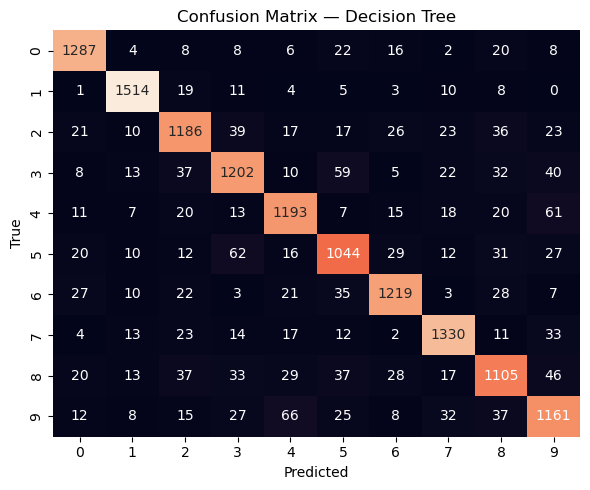

In [31]:
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=list(range(10)))
plt.figure(figsize=(6,5))
sns.heatmap(cm_dt, annot=True, fmt="d", cbar=False,
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Decision Tree")
plt.tight_layout()
plt.show()

## Misclassified Samples (Decision Tree)

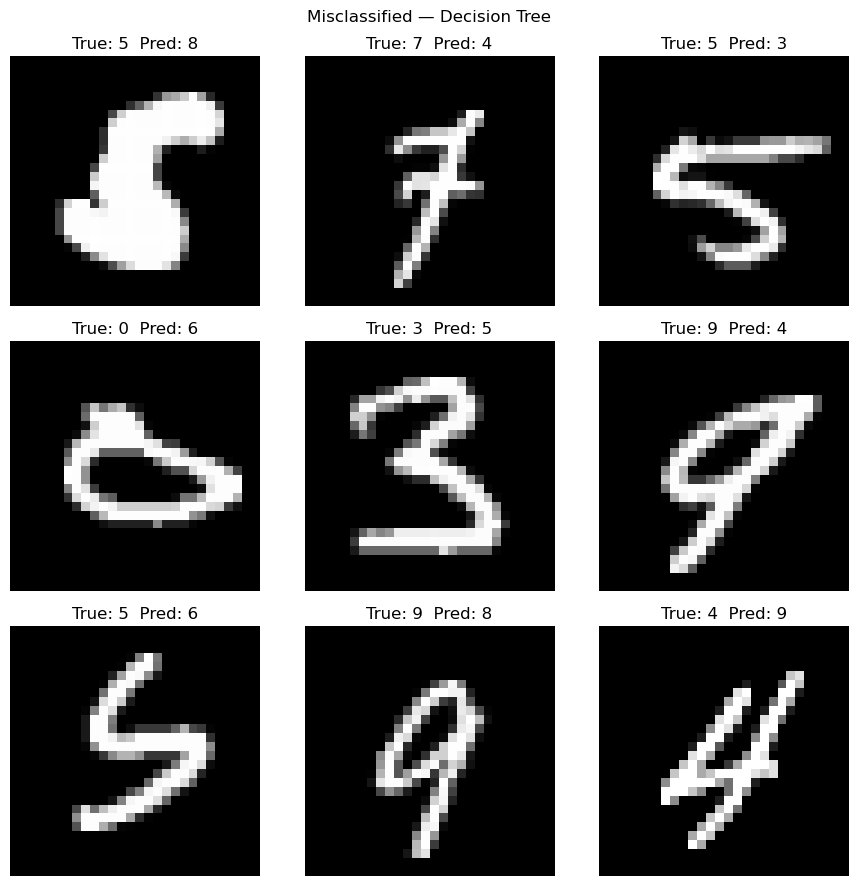

In [32]:
show_misclassified(
    X_test, y_test, y_pred_dt,
    n=9, img_size=(28, 28),
    title="Misclassified — Decision Tree"
)


## Tips to improve a Decision Tree

Training time (Decision Tree): 16.14s
Accuracy (Decision Tree): 0.8749 | Inference time: 0.05s

Classification Report — Decision Tree
              precision    recall  f1-score   support

           0     0.8944    0.9450    0.9190      1381
           1     0.9315    0.9676    0.9492      1575
           2     0.8539    0.8526    0.8533      1398
           3     0.8343    0.8459    0.8401      1428
           4     0.8579    0.8755    0.8666      1365
           5     0.8244    0.8290    0.8267      1263
           6     0.9075    0.8778    0.8924      1375
           7     0.9118    0.9143    0.9131      1459
           8     0.8680    0.8000    0.8326      1365
           9     0.8500    0.8231    0.8364      1391

    accuracy                         0.8749     14000
   macro avg     0.8734    0.8731    0.8729     14000
weighted avg     0.8747    0.8749    0.8745     14000



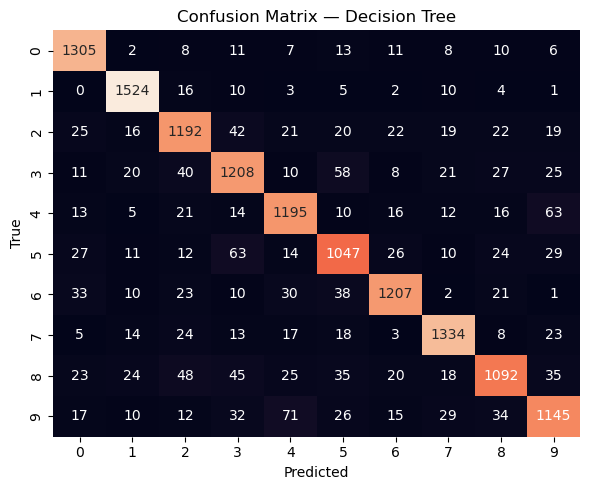

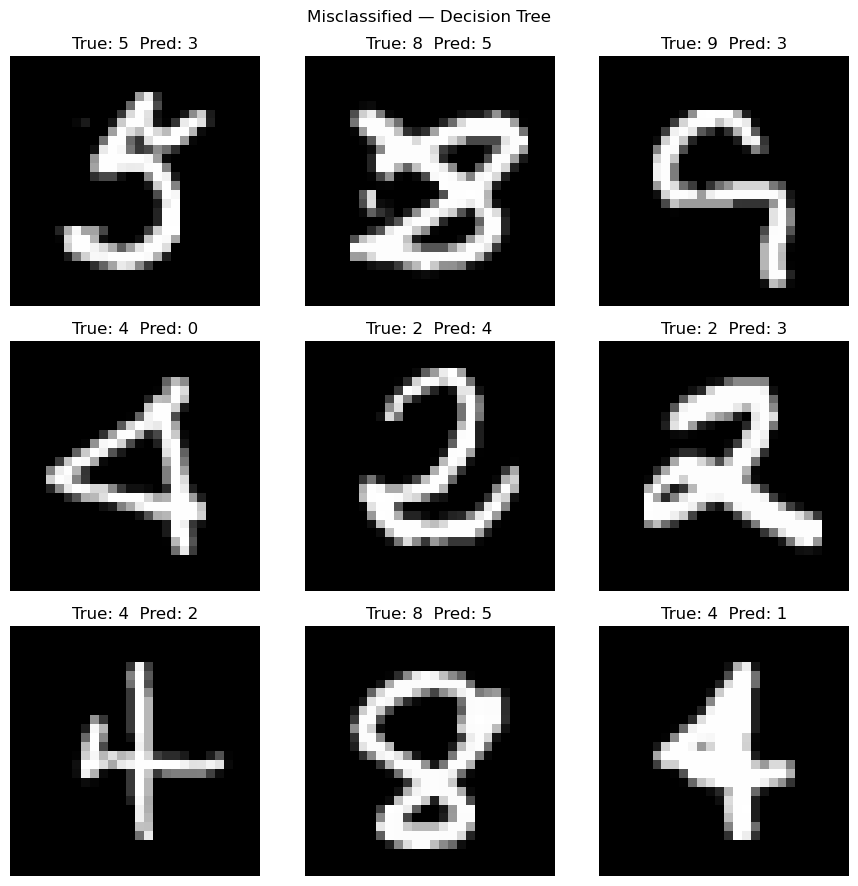

In [34]:
RANDOM_STATE = 42

# 1) Define model (tuned to reduce overfitting)
dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=20,
    min_samples_leaf=2
)

# 2) Train
t0 = time.perf_counter()
dt.fit(X_train, y_train)
dt_train_time = time.perf_counter() - t0
print(f"Training time (Decision Tree): {dt_train_time:.2f}s")

# 3) Predict & metrics
t1 = time.perf_counter()
y_pred_dt = dt.predict(X_test)
dt_infer_time = time.perf_counter() - t1

dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy (Decision Tree): {dt_acc:.4f} | Inference time: {dt_infer_time:.2f}s\n")

print("Classification Report — Decision Tree")
print(classification_report(y_test, y_pred_dt, digits=4))

# 4) Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=list(range(10)))
plt.figure(figsize=(6,5))
sns.heatmap(cm_dt, annot=True, fmt="d", cbar=False,
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Decision Tree")
plt.tight_layout()
plt.show()

# 5) Misclassified samples (uses your helper from earlier)
show_misclassified(
    X_test, y_test, y_pred_dt,
    n=9, img_size=(28, 28),
    title="Misclassified — Decision Tree"
)

## Random Forest Classifier

## Define & Train Random Forest

In [35]:
RANDOM_STATE = 42

rf = RandomForestClassifier(
    n_estimators=300,      # more trees → better stability (increase if you like)
    max_depth=None,        # let trees grow fully; tune to regularize if needed
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,             # use all CPU cores
    random_state=RANDOM_STATE
)

t0 = time.perf_counter()
rf.fit(X_train, y_train)
rf_train_time = time.perf_counter() - t0
print(f"Training time (Random Forest): {rf_train_time:.2f}s")


Training time (Random Forest): 22.46s


## Evaluate Random Forest (accuracy + report)

In [36]:
t1 = time.perf_counter()
y_pred_rf = rf.predict(X_test)
rf_infer_time = time.perf_counter() - t1

rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {rf_acc:.4f} | Inference time: {rf_infer_time:.2f}s\n")

print("Classification Report — Random Forest")
print(classification_report(y_test, y_pred_rf, digits=4))

Accuracy (Random Forest): 0.9687 | Inference time: 0.52s

Classification Report — Random Forest
              precision    recall  f1-score   support

           0     0.9730    0.9928    0.9828      1381
           1     0.9835    0.9841    0.9838      1575
           2     0.9678    0.9671    0.9674      1398
           3     0.9641    0.9601    0.9621      1428
           4     0.9726    0.9626    0.9676      1365
           5     0.9742    0.9572    0.9657      1263
           6     0.9740    0.9811    0.9775      1375
           7     0.9752    0.9712    0.9732      1459
           8     0.9556    0.9612    0.9584      1365
           9     0.9454    0.9468    0.9461      1391

    accuracy                         0.9687     14000
   macro avg     0.9686    0.9684    0.9685     14000
weighted avg     0.9687    0.9687    0.9687     14000



## Confusion Matrix (Random Forest)

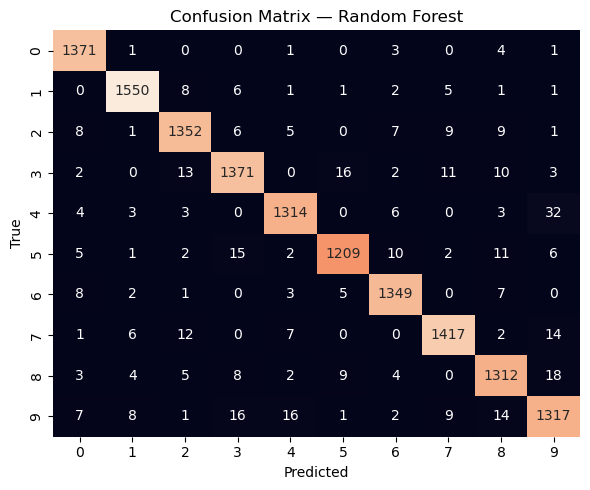

In [37]:
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=list(range(10)))
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cbar=False,
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

## Misclassified Samples (Random Forest)

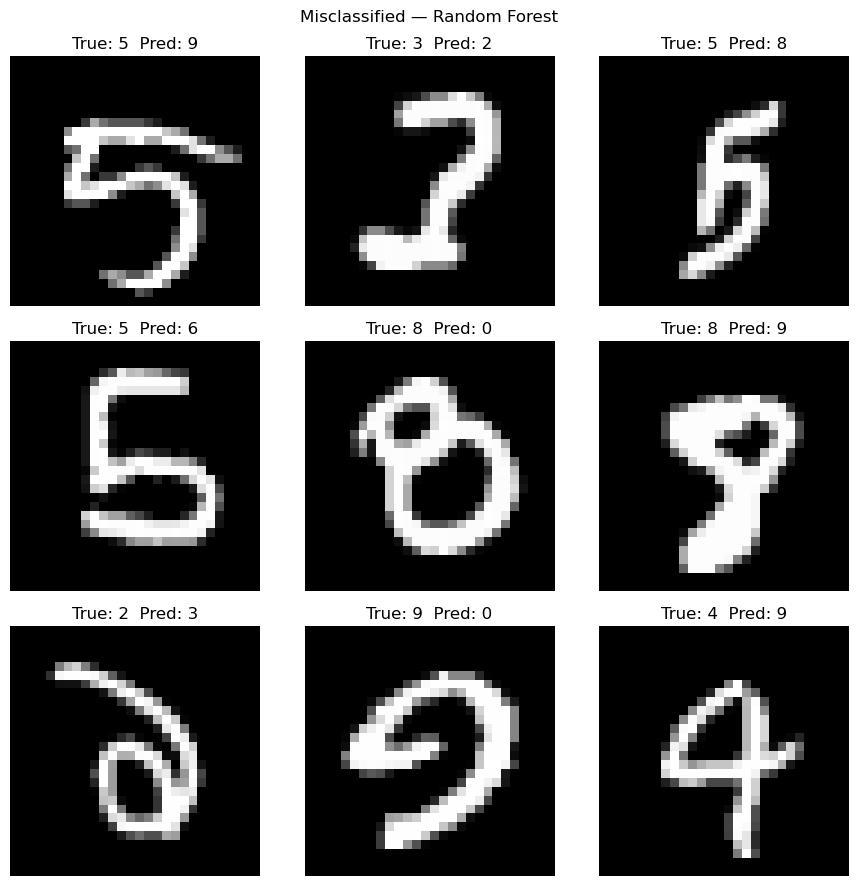

In [38]:
show_misclassified(
    X_test, y_test, y_pred_rf,
    n=9, img_size=(28, 28),
    title="Misclassified — Random Forest"
)

## XGBoost Classifier

## Import XGBoost (with a friendly fallback)

In [39]:
try:
    from xgboost import XGBClassifier
except ImportError:
    raise SystemExit("xgboost is not installed. Install with: pip install xgboost")

## Train XGBoost (multiclass with early stopping)

In [45]:
RANDOM_STATE = 42

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.10,
    stratify=y_train,
    random_state=RANDOM_STATE
)

In [46]:
xgb = XGBClassifier(
    objective="multi:softprob",   # predict class probabilities
    num_class=10,
    tree_method="hist",
    n_estimators=600,             # early stopping will prune this
    learning_rate=0.1,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)

## Fit (robust early stopping across versions)

In [47]:
t0 = time.perf_counter()

fit_kwargs = {"eval_set": [(X_val, y_val)], "verbose": False}
trained_with_es = False

try:
    # Works on many xgboost versions
    xgb.fit(X_tr, y_tr, early_stopping_rounds=25, **fit_kwargs)
    trained_with_es = True
except TypeError:
    # Fallback to callbacks API
    try:
        from xgboost.callback import EarlyStopping
        xgb.fit(X_tr, y_tr,
                callbacks=[EarlyStopping(rounds=25, save_best=True, maximize=False)],
                **fit_kwargs)
        trained_with_es = True
    except Exception:
        # Train without early stopping if neither is supported
        xgb.fit(X_tr, y_tr, **fit_kwargs)

xgb_train_time = time.perf_counter() - t0
best_iter = getattr(xgb, "best_iteration", None)
print(f"Training time (XGBoost): {xgb_train_time:.2f}s")
if trained_with_es and best_iter is not None:
    print(f"Best iteration used: {best_iter}")


Training time (XGBoost): 1163.93s


## Predict & Classification Report

In [48]:
t1 = time.perf_counter()
y_proba_xgb = xgb.predict_proba(X_test)      # since we used softprob
y_pred_xgb  = np.argmax(y_proba_xgb, axis=1) # class = argmax
xgb_infer_time = time.perf_counter() - t1

xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy (XGBoost): {xgb_acc:.4f} | Inference time: {xgb_infer_time:.2f}s\n")

print("Classification Report — XGBoost")
print(classification_report(y_test, y_pred_xgb, digits=4))

Accuracy (XGBoost): 0.9774 | Inference time: 0.63s

Classification Report — XGBoost
              precision    recall  f1-score   support

           0     0.9765    0.9942    0.9853      1381
           1     0.9879    0.9854    0.9866      1575
           2     0.9764    0.9757    0.9760      1398
           3     0.9789    0.9741    0.9765      1428
           4     0.9786    0.9736    0.9761      1365
           5     0.9816    0.9723    0.9769      1263
           6     0.9818    0.9833    0.9826      1375
           7     0.9754    0.9794    0.9774      1459
           8     0.9695    0.9773    0.9734      1365
           9     0.9666    0.9576    0.9621      1391

    accuracy                         0.9774     14000
   macro avg     0.9773    0.9773    0.9773     14000
weighted avg     0.9774    0.9774    0.9774     14000



## Confusion Matrix (XGBoost)

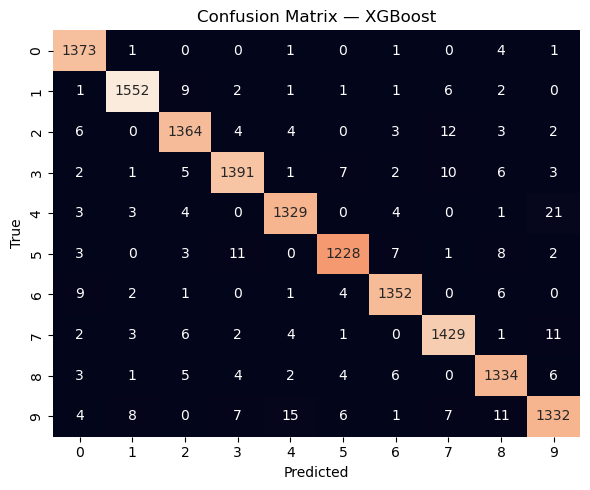

In [49]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=list(range(10)))

plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cbar=False,
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — XGBoost")
plt.tight_layout()
plt.show()

## Misclassified Samples (XGBoost)

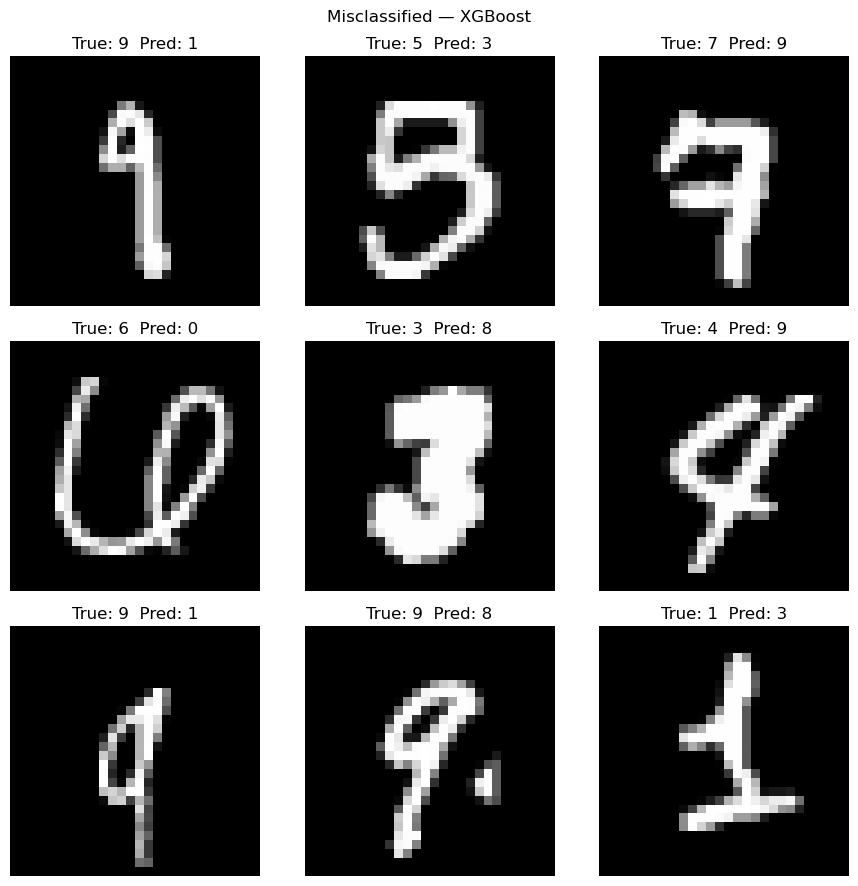

In [50]:
show_misclassified(
    X_test, y_test, y_pred_xgb,
    n=9, img_size=(28, 28),
    title="Misclassified — XGBoost"
)

## Feature Importance Heatmap (28×28)

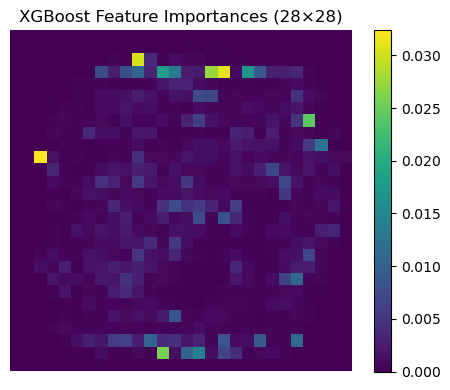

In [51]:
imp = xgb.feature_importances_
plt.figure(figsize=(5,4))
plt.imshow(imp.reshape(28, 28), cmap="viridis")
plt.title("XGBoost Feature Importances (28×28)")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

> To see which input pixels/features XGBoost relies on most by visualizing feature_importances_ as a 28×28 heatmap.

>To debug and trust the model—spot spurious cues/leakage and guide preprocessing or feature selection.

# Model Evaluation:

## Store and compare accuracy and other metrics across models.

In [55]:
rows = []

def add_row(name, acc_var, time_var):
    g = globals()
    if acc_var in g and time_var in g:
        rows.append((name, float(g[acc_var]), float(g[time_var])))

# Add rows from the variables you already computed
add_row("Logistic Regression", "logreg_acc", "logreg_train_time")

# Prefer RBF SVM; fall back to Linear SVM if needed
if "rbf_acc" in globals() and "rbf_train_time" in globals():
    add_row("SVM", "rbf_acc", "rbf_train_time")
elif "linsvm_acc" in globals() and "linsvm_train_time" in globals():
    add_row("SVM", "linsvm_acc", "linsvm_train_time")

add_row("Decision Tree", "dt_acc", "dt_train_time")
add_row("Random Forest", "rf_acc", "rf_train_time")
add_row("XGBoost", "xgb_acc", "xgb_train_time")

# Build DataFrame in the order added
df = pd.DataFrame(rows, columns=["Model", "Accuracy", "Training Time (s)"]).set_index("Model")

# Pretty style: rounding + zebra stripes
def zebra(row):
    i = df.index.get_loc(row.name)
    return ["background-color: #f5f7fa"] * len(row) if i % 2 == 0 else [""] * len(row)

styled = (
    df.round({"Accuracy": 4, "Training Time (s)": 2})
      .style
      .format({"Accuracy": "{:.4f}", "Training Time (s)": "{:.2f}"})
      .apply(zebra, axis=1)
)

styled

,Accuracy,Training Time (s)
Model,,
Logistic Regression,0.9161,37.22
SVM,0.9475,21.37
Decision Tree,0.8749,16.14
Random Forest,0.9687,22.46
XGBoost,0.9774,1163.93
